# Dự đoán bệnh tiểu đường (Pima Indians Diabetes)

## 1. Định nghĩa vấn đề (Define Problem)
+ **Mô tả**:
    + Bộ dữ liệu Pima Indians Diabetes được phát triển bởi National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK).
    + Dữ liệu gồm 768 phụ nữ người da đỏ Pima (≥ 21 tuổi), mỗi cá nhân được đo nhiều chỉ số lâm sàng và nhân khẩu học.
    + Mục tiêu: dự đoán xem một cá nhân có khả năng phát triển bệnh đái tháo đường type 2 trong vòng 5 năm hay không.
+ **Dữ liệu vào**:
    + Pregnancies — số lần mang thai
    + Glucose — nồng độ đường huyết 2 giờ sau nghiệm pháp dung nạp glucose (mg/dL)
    + BloodPressure — huyết áp tâm trương (mm Hg)
    + SkinThickness — độ dày lớp da gấp (mm)
    + Insulin — nồng độ insulin huyết thanh 2 giờ (mu U/ml)
    + BMI — chỉ số khối cơ thể (kg/m²)
    + DiabetesPedigreeFunction — hệ số di truyền bệnh tiểu đường (ước lượng nguy cơ dựa trên tiền sử gia đình)
    + Age — tuổi (năm)
+ **Kết quả**:
    + Outcome = 1 → dương tính (có chẩn đoán tiểu đường)
    + Outcome = 0 → âm tính (không có tiểu đường)


## 2. Chuẩn bị vấn đề (Prepare Problem)

### 2.1. Khai báo thư viện (Load Libraries)

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report,
                             precision_recall_curve, average_precision_score, brier_score_loss)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")
RND = 42
np.random.seed(RND)


### 2.2. Nạp dữ liệu (Load Dataset)

In [6]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/datasets/master/pima-indians-diabetes.data.csv"
col_names = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI',
             'DiabetesPedigreeFunction','Age','Outcome']
df = pd.read_csv(url, header=None, names=col_names)
print("Shape:", df.shape)
df.head()


Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 3. Phân tích dữ liệu (Analyze Data)

### 3.1. Thống kê mô tả (Descriptive Statistics)

#### (1) **Hiển thị một số thông tin về dữ liệu**
+ Số dòng, số cột của dữ liệu
+ Kiểu dữ liệu của từng cột
+ 5 dòng đầu và 5 dòng cuối của bảng dữ liệu
+ Thông tin chung về dữ liệu

In [8]:
# shape
print(f'+ Shape: {df.shape}')
# types
print(f'+ Data Types: \n{df.dtypes}')
# head, tail
print(f'+ Contents: ')
display(df.head(5))
display(df.tail(5))
# info
df.info()

+ Shape: (768, 9)
+ Data Types: 
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
+ Contents: 


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**Nhận xét**:
+ **Nhận xét dữ liệu**:
    + Dataset gồm 768 dòng, mỗi dòng tương ứng một cá nhân.
    + Có 8 đặc trưng đầu vào và 1 cột kết quả (Outcome).
    + Các biến đầu vào gồm số nguyên (Pregnancies, BloodPressure, SkinThickness, Insulin, Age) và số thực (BMI, DiabetesPedigreeFunction, Glucose).
    + Giá trị các đặc trưng được đo theo các đơn vị lâm sàng tương ứng: mm Hg, mg/dL, kg/m², năm, số lần mang thai.
    + Cột Outcome biểu diễn nhãn phân lớp: 1 = có bệnh tiểu đường, 0 = không có bệnh tiểu đường.
    + Dataset không có giá trị null nhưng một số biến có thể chứa giá trị 0 bất hợp lý (ví dụ Glucose = 0) cần xử lý trước khi huấn luyện.

#### (2) **Kiểm tra tính toàn vẹn của dữ liệu**
+ Dữ liệu có bị trùng lặp không? Hiển thị dòng bị vi phạm.
+ Dữ liệu có tồn tại giá trị Null không? Hiển thị dòng bị vi phạm.
+ Dữ liệu có tồn tại giá trị NaN không? Hiển thị dòng bị vi phạm.

In [9]:
has_null = df.isnull().sum().any()
has_nan  = df.isna().sum().any()
n_duplicated = df.duplicated().sum()
print(f'Tính toàn vẹn dữ liệu:')
print(f'+ Có giá trị Null: {has_null}')
if has_null:
    display.display(df[df.isnull().any(axis=1)])
print(f'+ Có giá trị Nan: {has_nan}')
if has_nan:
    display.display(df[df.isna().any(axis=1)])
print(f'+ Số dòng trùng: {n_duplicated}')
if n_duplicated>0:
    s_query1 = "`sepal-length`==4.9 and `sepal-width`==3.1 and `class`=='Iris-setosa'"
    s_query2 = "`sepal-length`==5.8 and `sepal-width`==2.7 and `class`=='Iris-virginica'"
    display.display(df.query(s_query1))
    display.display(df.query(s_query2))
    display.display(df[df.duplicated()])

Tính toàn vẹn dữ liệu:
+ Có giá trị Null: False
+ Có giá trị Nan: False
+ Số dòng trùng: 0


**Nhận xét**:
+ Dữ liệu không có dòng bị trùng
+ Dữ liệu không có giá trị rỗng (NaN, Null)

#### (3) **Các tính chất thống kê trên dữ liệu số**
+ Count, Mean, Standard Deviation, Minimum Value
+ 25th Percentile, 50th Percentile (Median), 75th Percentile, Maximum Value

In [12]:
description = df.describe().T
display(description)

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


+ **Nhận xét **:
   + Các đặc trưng có đơn vị đo khác nhau: số lần mang thai, mg/dL, mm Hg, mm, mu U/ml, kg/m², hệ số di truyền, tuổi.  
    + Giá trị của các đặc trưng nằm trong các khoảng:  
        - Pregnancies: 0 – 17  
        - Glucose: 0 – 199  
        - BloodPressure: 0 – 122  
        - SkinThickness: 0 – 99  
        - Insulin: 0 – 846  
        - BMI: 0 – 67.1  
        - DiabetesPedigreeFunction: 0.078 – 2.42  
        - Age: 21 – 81  
    + Cột Outcome là nhãn phân lớp: 0 = không có tiểu đường, 1 = có tiểu đường, khoảng 35% mẫu có bệnh tiểu đường.  
   


#### (4) **Tần số xuất hiện (Distribution) trên dữ liệu phân lớp (Class) và dữ liệu danh mục (Category)**

Đối với bài toán phân lớp (classification problem), chúng ta cần tính số lần xuất hiện của thuộc tính phân lớp. Điều này là cần thiết cho vấn đề mất cân bằng (highly imbalanced problems) giữa các lớp nhằm cần xử lý đặc biệt trong bước chuẩn bị dữ liệu.

In [14]:
df["Outcome"].value_counts()


,count
Outcome,
0,500
1,268


**Nhận xét**:
+ Dữ liệu cần phân loại Có bệnh (1) và Không có bệnh (0)
+ Các lớp là chênh lệch nhau và có số lượng Có bệnh (1): 500 và Không có bệnh (0): 268

#### (5) **Mối tương quan giữa các tính chất (Correlations)**

Sự tương quan (correlation) đề cập đến mối quan hệ giữa hai biến và cách chúng có thể có hoặc không cùng nhau thay đổi.

Phương pháp phổ biến nhất để tính toán tương quan là Pearson's Correlation Coeficient, giả định có một phân phối chuẩn của các thuộc tính liên quan. Tương quan -1 hoặc 1 cho thấy mối tương quan âm hoặc dương đầy đủ tương ứng. Trong khi giá trị 0 hiển thị không tương quan ở tất cả.

$$
r = \frac{\sum_{i=1}^n{\left(x_i - \hat{x}\right)\left(y_i - \hat{y}\right)}}{\sqrt{\sum_{i=1}^n{\left(x_i - \hat{x}\right)^2}\sum_{i=1}^n{\left(y_i - \hat{y}\right)^2}}}
$$

Một số thuật toán học máy như hồi quy tuyến tính và logistic có hiệu suất kém nếu có các thuộc tính tương quan cao trong tập dữ liệu của bạn.

Như vậy, thật sự cần thiết để xem xét tất cả các mối tương quan theo cặp của các thuộc tính trong tập dữ liệu.

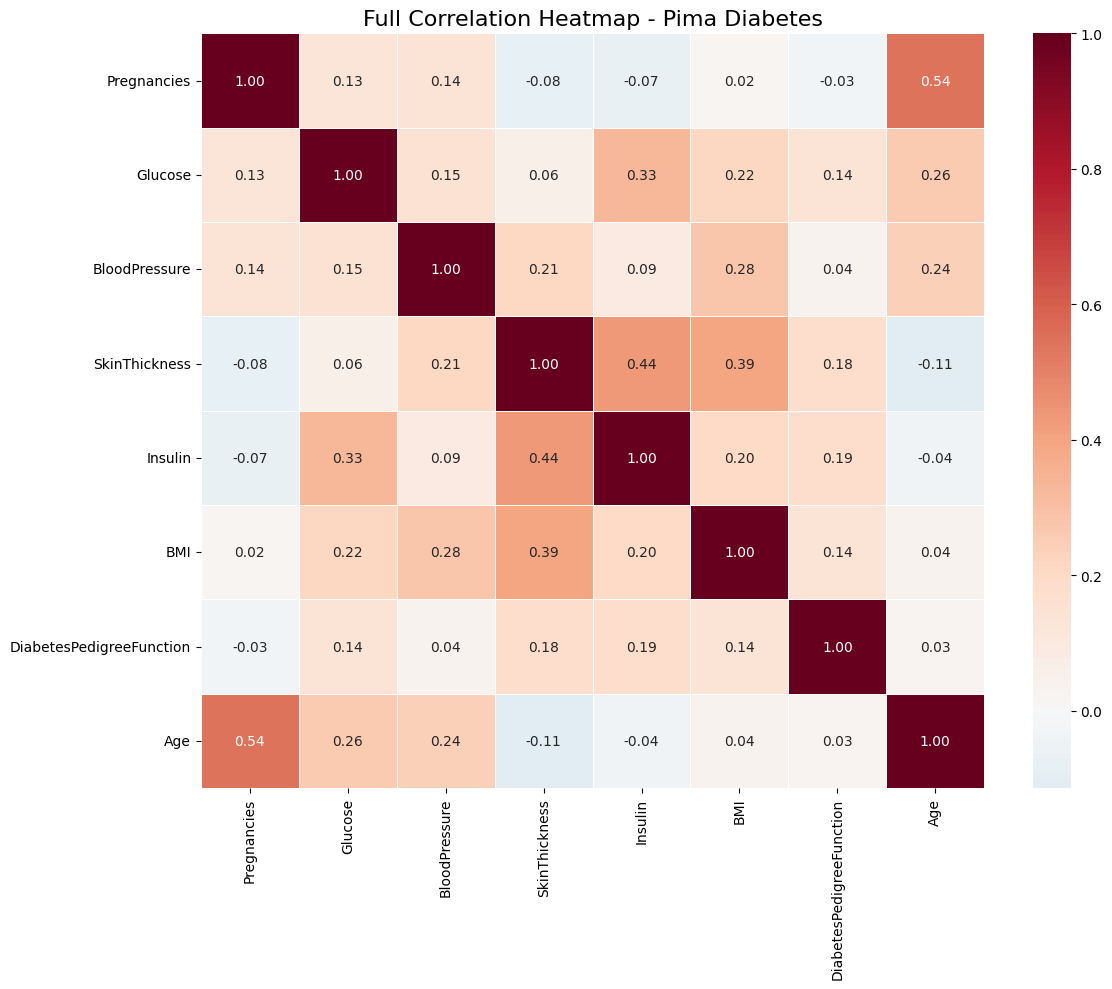

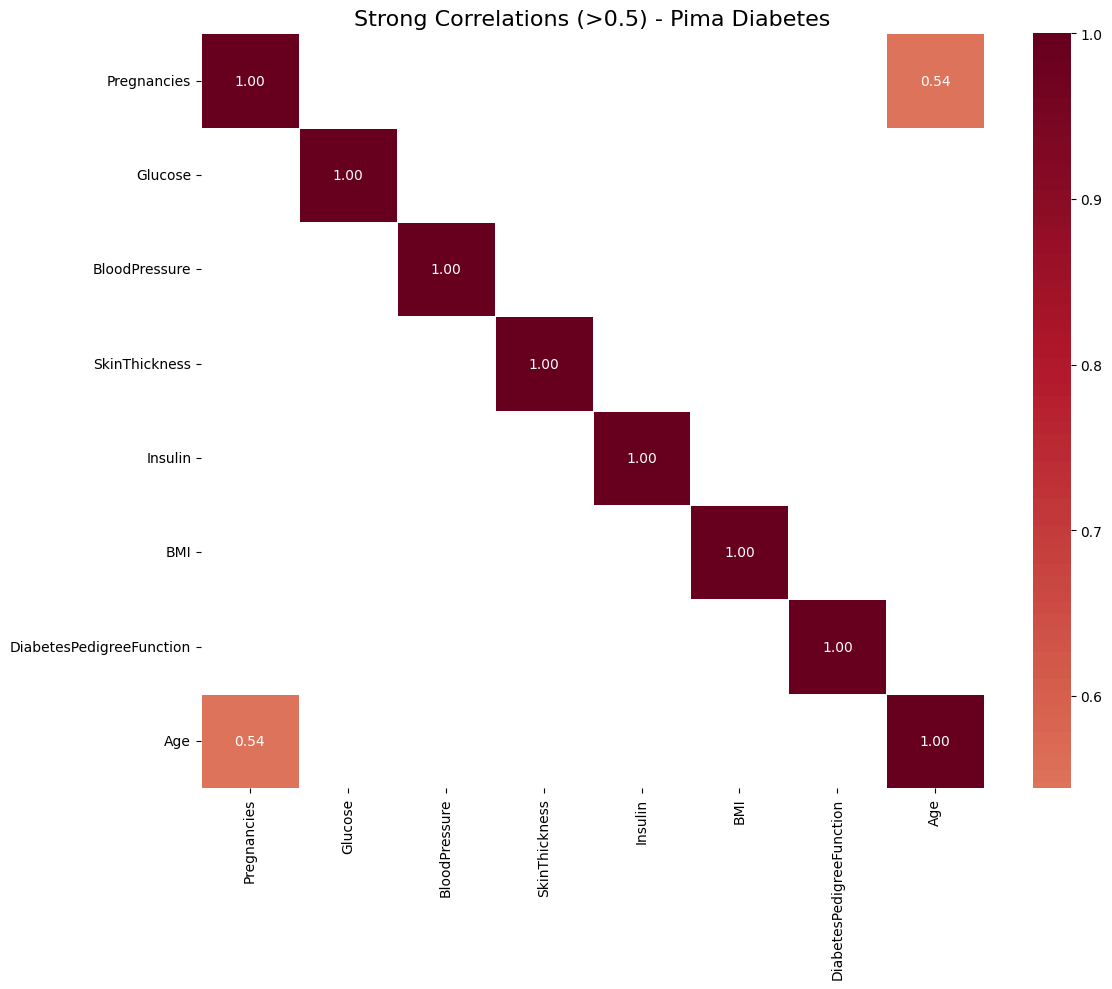

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# df = pd.read_csv("diabetes.csv")

# Chỉ lấy các numeric features
features = df.drop(columns=["Outcome"])
corr = features.corr()

# Full heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, linewidths=.5)
plt.title("Full Correlation Heatmap - Pima Diabetes", fontsize=16)
plt.tight_layout()
plt.savefig("corr_full.png")
plt.show()

# Heatmap các mối tương quan mạnh (>0.5 hoặc <-0.5)
mask = np.abs(corr) < 0.5  # False = hiển thị, True = ẩn
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, linewidths=.5, mask=mask)
plt.title("Strong Correlations (>0.5) - Pima Diabetes", fontsize=16)
plt.tight_layout()
plt.savefig("corr_strong.png")
plt.show()


In [17]:
correlations = df.corr(method='pearson')
display(correlations)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


## Nhận xét về mối tương quan

+ **Các cặp tính chất có tương quan đáng chú ý**:
    - **Pregnancies vs Age**: r = 0.544 → số lần mang thai tỉ lệ thuận với tuổi, hợp lý về mặt sinh học.
    - **Glucose vs Outcome**: r = 0.467 → mức đường huyết càng cao, khả năng mắc tiểu đường càng lớn.
    - **BMI vs Outcome**: r = 0.293 → BMI cao tỉ lệ thuận với nguy cơ mắc bệnh.
    - **SkinThickness vs Insulin**: r = 0.437 → nồng độ insulin và độ dày da có sự liên quan nhẹ.




### 3.2. Hiển thị dữ liệu (Visualize Data)

#### (1) Hiển thị trên từng tính chất đơn (Univariate Plots)

**Box and whisker plots**
+ https://www.simplypsychology.org/boxplots.html
+ So sánh các trung vị (median) tương ứng của mỗi ô hộp (box plot). Nếu đường trung vị của một ô hộp nằm bên ngoài ô của một ô hộp so sánh, thì có thể có sự khác biệt giữa hai nhóm.
+ So sánh chiều dài hộp để kiểm tra cách dữ liệu được phân tán giữa mỗi mẫu. Hộp càng dài thì dữ liệu càng phân tán. Dữ liệu càng nhỏ càng ít bị phân tán.
+ Một ngoại lệ (outlier) được định nghĩa là một điểm dữ liệu nằm bên ngoài phần rìa (whiskers) của ô hộp.
+ Kiểm tra hướng lệch của dữ liệu (cân đối, các phần tử tập trung trái, phải).
    + Median ở giữa hộp và râu (whiskers) ở hai bên như nhau thì phân bố là đối xứng.
    + Median ở gần đáy hộp hơn và nếu râu ngắn hơn ở đầu dưới của hộp, thì phân phối là lệch dương (lệch phải).
    + Median ở gần đầu hộp hơn và nếu râu ngắn hơn ở đầu trên của hộp, thì phân bố bị lệch âm (lệch trái).

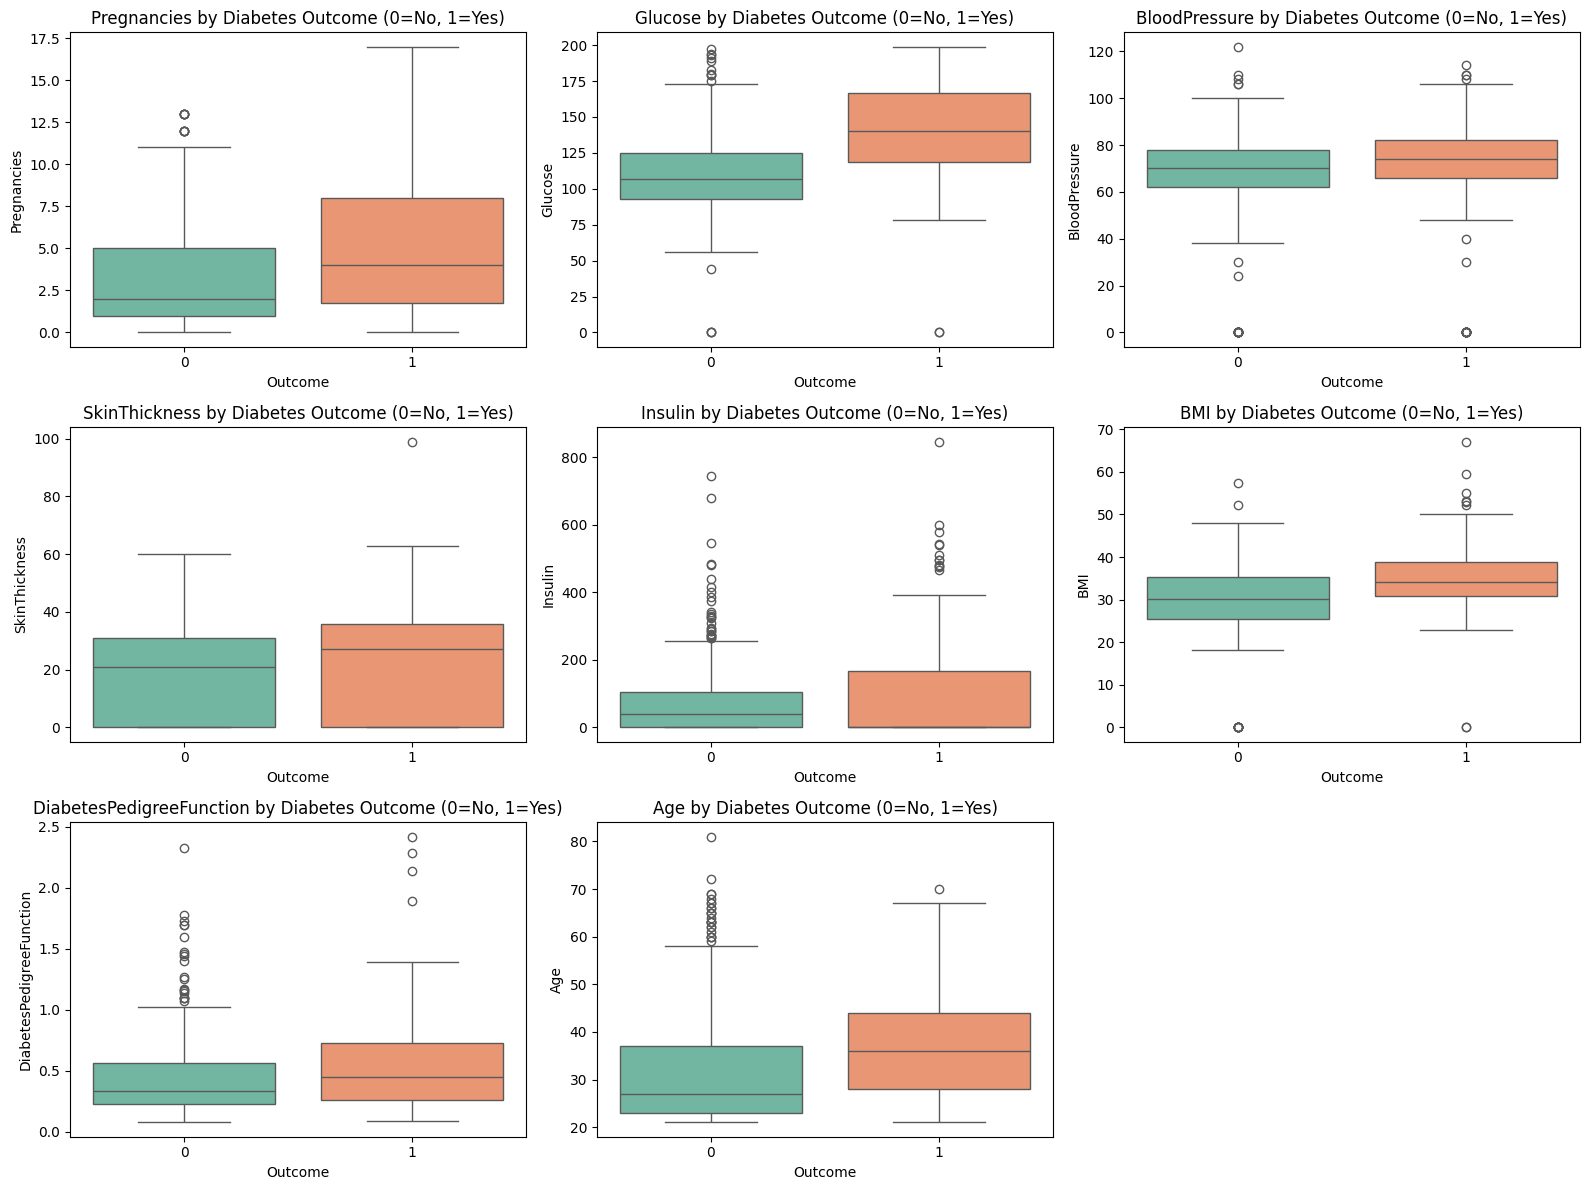

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
           "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
data = pd.read_csv(url, names=columns)

# Vẽ boxplots cho từng biến, so sánh theo Outcome
plt.figure(figsize=(16,12))
for i, col in enumerate(columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x="Outcome", y=col, data=data, palette="Set2")
    plt.title(f"{col} by Diabetes Outcome (0=No, 1=Yes)")

plt.tight_layout()
plt.show()



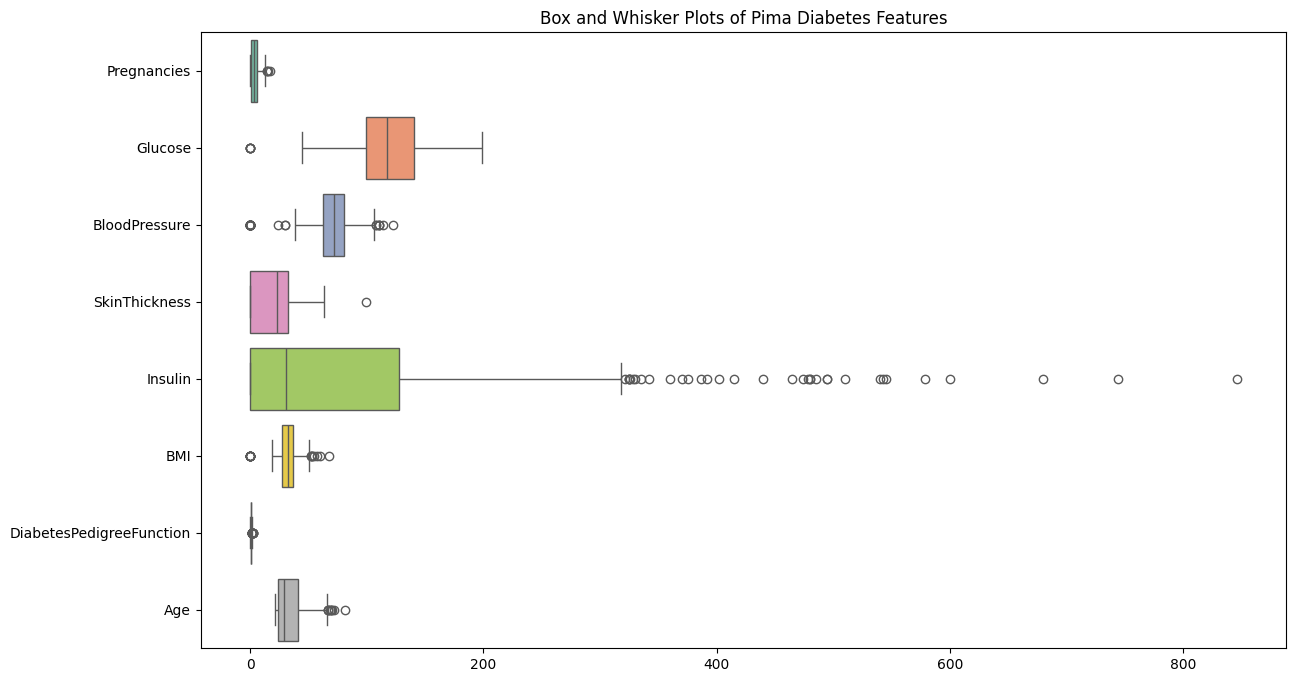

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,8))
sns.boxplot(data=df.drop(columns=["Outcome"]), orient='h', palette="Set2")
plt.title("Box and Whisker Plots of Pima Diabetes Features")
plt.show()


- Trung vị (median) của mỗi ô hộp giúp so sánh vị trí tập trung dữ liệu giữa các biến.  
- Chiều dài hộp (interquartile range) thể hiện mức độ phân tán dữ liệu. Hộp dài → dữ liệu phân tán rộng; hộp ngắn → dữ liệu tập trung.  
- Ngoại lệ (outlier) là những điểm nằm ngoài whiskers.  
- Hướng lệch (skewness) thể hiện tính đối xứng của phân bố:  
  - Median gần giữa hộp → phân bố cân bằng.  
  - Median lệch về phía dưới → lệch phải (positive skew).  
  - Median lệch về phía trên → lệch trái (negative skew).

**Biểu đồ Histogram**

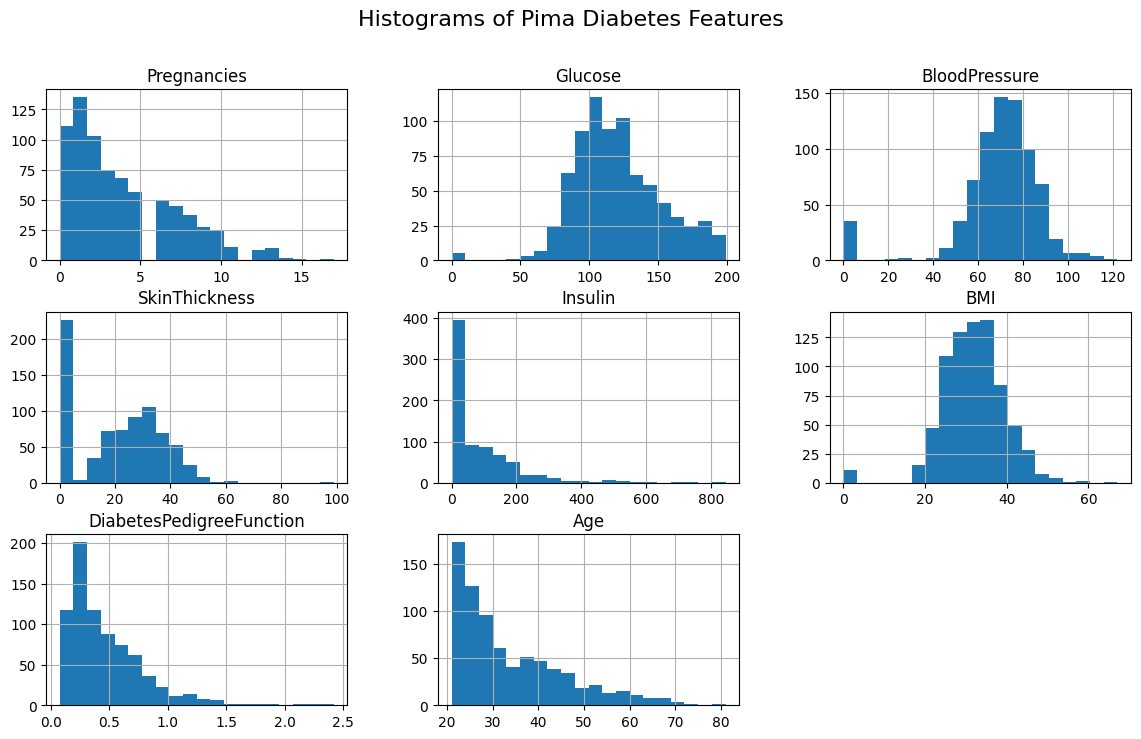

In [27]:
df.drop(columns=["Outcome"]).hist(figsize=(14,8), bins=20, layout=(3,3), sharex=False, sharey=False)
plt.suptitle("Histograms of Pima Diabetes Features", fontsize=16)
plt.show()


#### (2) Hiển thị nhiều tính chất (Multivariate Plots)

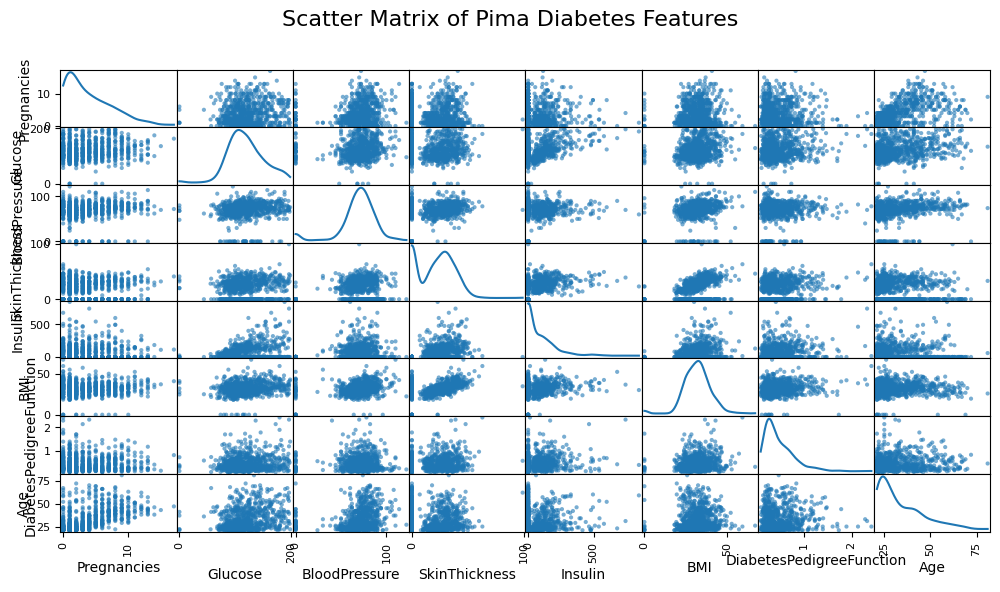

In [28]:
# Multivariate Scatter Matrix
from pandas.plotting import scatter_matrix

# Không hiển thị biến Outcome trong scatter matrix vì là nhị phân
scatter_matrix(df.drop(columns=["Outcome"]), figsize=(12,6), diagonal='kde', alpha=0.6)
plt.suptitle("Scatter Matrix of Pima Diabetes Features", fontsize=16)
plt.show()


+ Các cặp tính chất có độ tương đồng tương đối cao:
    + (SkinThickness, Insulin) = 0.437 → mối quan hệ dương vừa phải, khi da dày hơn, insulin thường cao hơn.  
    + (BMI, Outcome) = 0.293 → BMI cao liên quan nhẹ đến khả năng mắc bệnh.  
    + (Glucose, Outcome) = 0.467 → Glucose là biến quan trọng, có mối liên hệ rõ ràng với kết quả.  
    + (Pregnancies, Age) = 0.544 → Số lần mang thai tăng theo tuổi.  


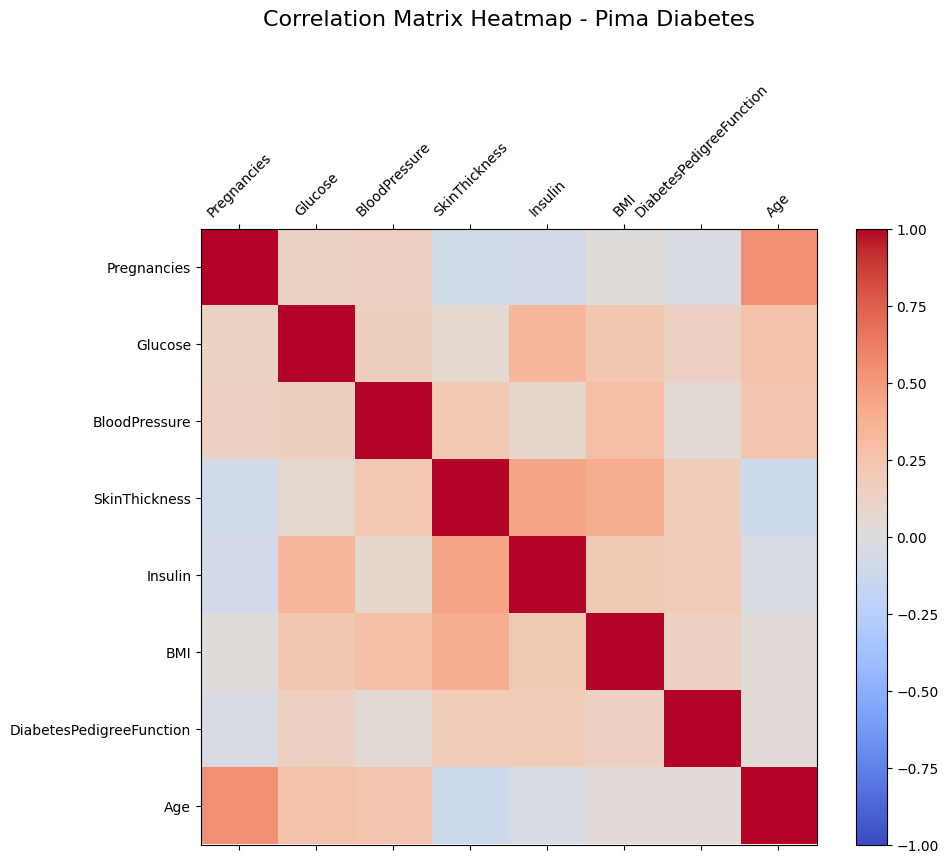

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy ma trận tương quan và chuyển sang numpy array
correlations = df.drop(columns=["Outcome"]).corr()
corr_matrix = correlations.values  # chuyển DataFrame -> numpy array

plt.figure(figsize=(10,8))
plt.matshow(corr_matrix, fignum=0, vmin=-1, vmax=1, cmap='coolwarm')  # fignum=0 để tránh xung đột
plt.colorbar()
plt.xticks(np.arange(len(correlations.columns)), correlations.columns, rotation=45)
plt.yticks(np.arange(len(correlations.columns)), correlations.columns)
plt.title("Correlation Matrix Heatmap - Pima Diabetes", pad=40, fontsize=16)
plt.show()



## 4. Chuẩn bị dữ liệu (Prepare Data)

### 4.1. Làm sạch dữ liệu (Data Cleaning)

#### (1) **Tạo bảng dữ liệu làm sạch**
+ Chỉ giữ lại các cột Input, Ouput

In [31]:
df_clean = df.copy()

#### (2) **Xóa dữ liệu trùng nhau**

In [32]:
display(df[df.duplicated()])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


#### (3) **Xử lý giá trị rỗng, không hợp lệ**

In [34]:
has_null = df.isnull().sum().any()
has_nan  = df.isna().sum().any()
print(f'+ Có giá trị Null: {has_null}')
if has_null:
    display.display(df[df.isnull().any(axis=1)])
print(f'+ Có giá trị Nan: {has_nan}')
if has_nan:
    display(df[df.isna().any(axis=1)])

+ Có giá trị Null: False
+ Có giá trị Nan: False


### 4.2. Biến đổi dữ liệu (Data Transforms)

#### (1) Chuyển đổi dữ liệu danh mục (Category) thành dữ liệu số

In [35]:
from sklearn.preprocessing import LabelEncoder

class_encoder = LabelEncoder()
class_encoder.fit(df_clean["Outcome"])   # đổi từ "class" → "Outcome"
class_names = class_encoder.classes_
print(class_names)


[0 1]


In [36]:
y_encoded = class_encoder.transform(df_clean["Outcome"])
y_encoded[:10]  # xem 10 giá trị đầu


array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1])

In [37]:
# Chuyển nhãn Outcome thành số nếu muốn
from sklearn.preprocessing import LabelEncoder

class_encoder = LabelEncoder()
df_clean["Outcome_encoded"] = class_encoder.fit_transform(df_clean["Outcome"])

# Kiểm tra kết quả
df_clean.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Outcome_encoded
0,6,148,72,35,0,33.6,0.627,50,1,1
1,1,85,66,29,0,26.6,0.351,31,0,0
2,8,183,64,0,0,23.3,0.672,32,1,1
3,1,89,66,23,94,28.1,0.167,21,0,0
4,0,137,40,35,168,43.1,2.288,33,1,1


#### (2) Chuyển đổi dữ liệu danh mục (Category) thành dạng OneHot

Một số thuật toán khi chuyển đổi cột dạng danh mục thành kiểu OneHot thì cho hiệu suất cao hơn.

Bên cạnh đó, khi huấn luyện mô hình với dạng hàm mất mát CategoryEntropy thì cũng cần chuyển thuộc tính phân lớp sang dạng OneHot.

#### (3) Chuẩn hóa dữ liệu (Data Normalize)

Chuẩn hóa các tính chất để đưa về cùng một miền trị
+ Min-Max Normalization
$$
z = \frac{x - min(x)}{max(x) - min(x)}
$$
+ Standard Normalization
$$
z = \frac{x - \mu}{\sigma}
$$

**Lưu ý**: Quá trình chuẩn hóa có thể làm trong phần thực nghiệm thuật toán

In [39]:
from sklearn.preprocessing import MinMaxScaler

# Các cột số để chuẩn hóa
scale_columns = ["Pregnancies", "Glucose", "BloodPressure",
                 "SkinThickness", "Insulin", "BMI",
                 "DiabetesPedigreeFunction", "Age"]

# Khởi tạo MinMaxScaler
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(df[scale_columns])

# Tạo bản sao dữ liệu và chuẩn hóa
df_minmax = df.copy()
df_minmax[scale_columns] = minmax_scaler.transform(df[scale_columns])

# Hiển thị kết quả
df_minmax.head(10)  # hiển thị 10 dòng đầu tiên



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1
5,0.294118,0.582915,0.606557,0.000000,0.000000,0.381520,0.052519,0.150000,0
6,0.176471,0.391960,0.409836,0.323232,0.104019,0.461997,0.072588,0.083333,1
7,0.588235,0.577889,0.000000,0.000000,0.000000,0.526080,0.023911,0.133333,0
8,0.117647,0.989950,0.573770,0.454545,0.641844,0.454545,0.034159,0.533333,1
9,0.470588,0.628141,0.786885,0.000000,0.000000,0.000000,0.065756,0.550000,1


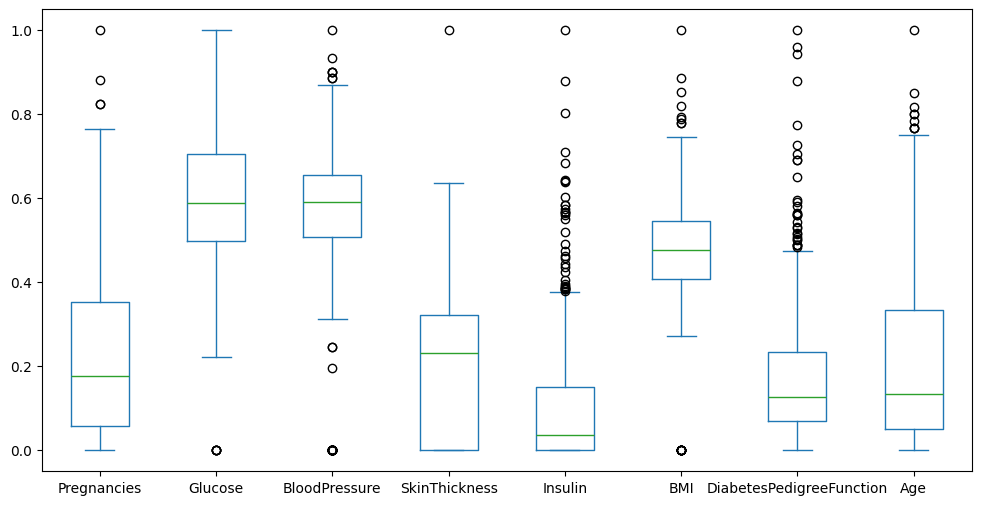

In [40]:
df_clean_minmax[scale_columns].plot(kind="box", figsize=(12,6));

In [41]:
# Standard Normalization
standard_scaler = StandardScaler()
standard_scaler.fit(df_clean[scale_columns])
df_clean_standard = df_clean.copy()
df_clean_standard[scale_columns] = standard_scaler.transform(df_clean[scale_columns])
df_clean_standard

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Outcome_encoded
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0,0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1,1
...,...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,0.870031,0.115169,-0.908682,2.532136,0,0
764,-0.547919,0.034598,0.046245,0.405445,-0.692891,0.610154,-0.398282,-0.531023,0,0
765,0.342981,0.003301,0.149641,0.154533,0.279594,-0.735190,-0.685193,-0.275760,0,0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.692891,-0.240205,-0.371101,1.170732,1,1


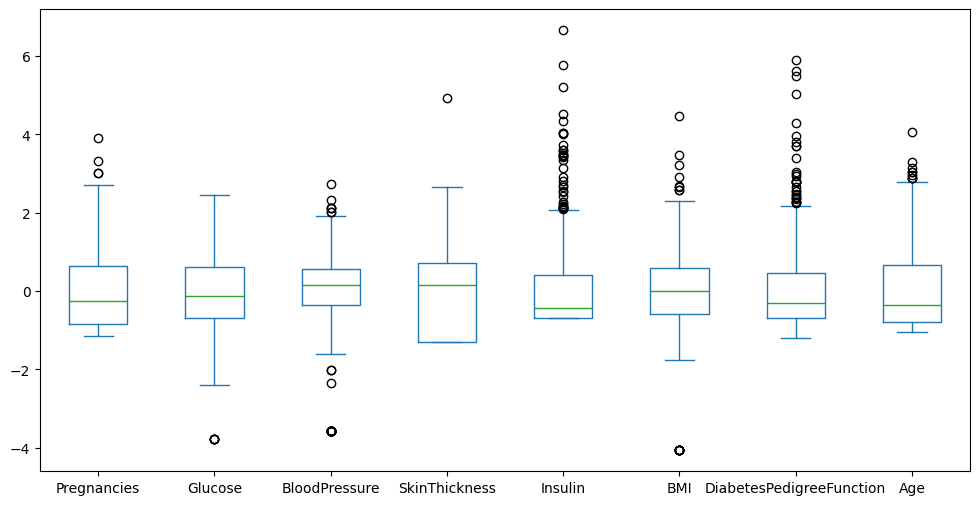

In [42]:
df_clean_standard[scale_columns].plot(kind="box", figsize=(12,6));

In [44]:
correlations = df_clean_standard.corr(method='pearson')
display(correlations)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Outcome_encoded
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000,1.000000
Outcome_encoded,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000,1.000000


#### (4) Chia dữ liệu thực nghiệm

+ Chuyển đổi dữ liệu sang dạng numpy với phần Input (X_data), Output (y_data)
+ Chia dữ liệu thành tập train/test (tỷ lệ 70/30)
+ Lưu tất cả thông tin để chuẩn bị chạy thuật toán

In [47]:
from sklearn.model_selection import train_test_split

X_data, y_data = df_minmax.values[:, :-1], df_minmax.values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.3, random_state=42, stratify=y_data
)

print(X_train.shape, X_test.shape)
print(y_train[:20])


(537, 8) (231, 8)
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7)
print(f'+ Train/Test: Train Ratio = {len(X_train)/len(X_data)}')
print(f'+ Train: shape={X_train.shape}\nInput = \n{X_train[:5]}\nOutput = {y_train[:5]}')
print(f'+ Test: shape={X_test.shape}\nInput = \n{X_test[:5]}\nOutput = {y_test[:5]}')

+ Train/Test: Train Ratio = 0.69921875
+ Train: shape=(537, 8)
Input = 
[[0.05882353 0.47738693 0.49180328 0.18181818 0.06855792 0.3561848
  0.07771136 0.01666667]
 [0.29411765 0.52763819 0.59016393 0.29292929 0.38416076 0.54992548
  0.03458582 0.11666667]
 [0.         0.67839196 0.55737705 0.42424242 0.29550827 0.63040238
  0.12254483 0.05      ]
 [0.23529412 0.65829146 0.55737705 0.21212121 0.19621749 0.49329359
  0.03501281 0.11666667]
 [0.05882353 0.51758794 0.24590164 0.38383838 0.09810875 0.64530551
  0.04483348 0.2       ]]
Output = [0. 0. 1. 0. 0.]
+ Test: shape=(231, 8)
Input = 
[[0.35294118 0.49246231 0.47540984 0.33333333 0.22458629 0.50670641
  0.15029889 0.36666667]
 [0.11764706 0.56281407 0.6147541  0.32323232 0.         0.53204173
  0.02988898 0.        ]
 [0.11764706 0.54271357 0.52459016 0.         0.         0.45901639
  0.03415884 0.        ]
 [0.47058824 0.53768844 0.6557377  0.         0.         0.36661699
  0.33219471 0.21666667]
 [0.41176471 0.68341709 0.7377049

In [49]:
# Lưu thông tin
save_dir = "exps/iris"
if os.path.exists(save_dir) == False: os.makedirs(save_dir)

# Save training data
np.savez(f'{save_dir}/data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
# Save cleaning data
df_clean.to_excel(f'{save_dir}/df_clean.xlsx', index=False)
# Save encoders
joblib.dump(class_encoder, f'{save_dir}/class_encoder.joblib')

os.listdir(save_dir)

['df_clean.xlsx', 'data.npz', 'class_encoder.joblib']

In [50]:
# Kiểm tra phục hồi dữ liệu
dict(np.load(f'{save_dir}/data.npz')).keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])

In [51]:
pd.read_excel(f'{save_dir}/df_clean.xlsx')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Outcome_encoded
0,6,148,72,35,0,33.6,0.627,50,1,1
1,1,85,66,29,0,26.6,0.351,31,0,0
2,8,183,64,0,0,23.3,0.672,32,1,1
3,1,89,66,23,94,28.1,0.167,21,0,0
4,0,137,40,35,168,43.1,2.288,33,1,1
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0
764,2,122,70,27,0,36.8,0.340,27,0,0
765,5,121,72,23,112,26.2,0.245,30,0,0
766,1,126,60,0,0,30.1,0.349,47,1,1


In [52]:
joblib.load(f'{save_dir}/class_encoder.joblib').classes_

array([0, 1])

# Kết thúc